# MNIST Denoising Autoencoder

## Reference
- http://deeplearning.net/tutorial/dA.html
- https://gist.github.com/blackecho/3a6e4d512d3aa8aa6cf9
- https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist.ipynb
- http://stats.stackexchange.com/questions/194426/denoising-autoencoder-not-training-properly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
%matplotlib inline

### Data loading

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
input_dim = 784
output_dim = 784

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Data visualization

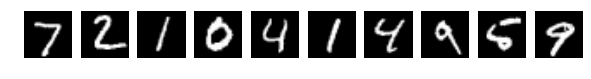

In [3]:
no_plot_img = 10
plt.rcParams['figure.figsize'] = (10, 1)
fig, ax_list = plt.subplots(1, no_plot_img)
for i in range(no_plot_img):
    image = mnist.test.images[i].reshape((28, 28))
    label = np.argmax(mnist.test.labels[i])
    ax_list[i].axis('off')
    ax_list[i].imshow(image, cmap='gray')
plt.show()

## Design

In [4]:
hidden_dim = 400

with tf.device('/gpu:0'):
    # Dropout rate
    dr = tf.placeholder(tf.float32)

    # Input and output
    x  = tf.placeholder(tf.float32, [None, input_dim])
    y  = tf.placeholder(tf.float32, [None, output_dim])

    # Encoding
    W1 = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b1 = tf.Variable(tf.random_normal([1]))
    h2 = tf.sigmoid(tf.add(tf.matmul(x, W1), b1))
    h2_d = tf.nn.dropout(h2, 1 - dr)

    # Decoding
    W2 = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b2 = tf.Variable(tf.random_normal([1]))
    h = tf.sigmoid(tf.add(tf.matmul(h2_d, W2), b2))

    # Cost function
    cost_reconstruction = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(y, h))))
    cost_regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    reg_coeff = tf.placeholder(tf.float32)
    cost = cost_reconstruction + reg_coeff * cost_regularization
    train_op = tf.train.AdamOptimizer(tf.Variable(0.005)).minimize(cost)

## Training

In [5]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    dropout_rate = 0.25
    regularization_coefficient = 0.000001
    num_epochs = 50
    batch_size = 256
    tf.global_variables_initializer().run(session = sess)
    
    costs = []
    for i in xrange(num_epochs):
        # Fit the model
        for j in xrange(mnist.train.num_examples / batch_size):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            noise = 0.3 * np.random.randn(batch_size, input_dim)
            batch_X_noisy = batch_X + noise
            sess.run(train_op, feed_dict={
                    x:batch_X_noisy,
                    y:batch_X,
                    reg_coeff:regularization_coefficient,
                    dr:dropout_rate})
        weights = sess.run(W1).T
        
        # Deal with cost
        val_feed_dict = {
            x:mnist.train.images[:1000],
            y:mnist.train.images[:1000],
            reg_coeff:regularization_coefficient,
            dr:0.0}
        cost_val_train_1 = sess.run(cost_reconstruction, feed_dict=val_feed_dict)
        cost_val_train_2 = sess.run(cost_regularization, feed_dict=val_feed_dict)
        cost_val = cost_val_train_1 + regularization_coefficient*cost_val_train_2
        costs.append(cost_val)
        
        # Print the result and save the visualized weights
        if (i == 0) or (((i+1) % 5) == 0):
            print('%d\t%f\t%f\t%f'%(
                    i+1,
                    cost_val_train_1,
                    regularization_coefficient*cost_val_train_2,
                    cost_val))
            
#         tile_size = int(np.sqrt(weights.shape[0]))
#         tile_len = int(np.sqrt(weights.shape[1]))
#         plt.rcParams['figure.figsize'] = (10, 10)
#         fig, ax_list = plt.subplots(tile_size, tile_size)
#         fig.suptitle('MNIST Denoising Autoencoder (%d epochs)'%(i+1),
#                 fontsize=20,
#                 color='white',
#                 fontweight='bold')
#         for row_i in range(tile_size):
#             for col_i in range(tile_size):
#                 image = weights[row_i * tile_size + col_i]
#                 max_val = np.max(image)
#                 min_val = np.min(image)
#                 norm_image = image
#                 norm_image = norm_image.reshape((tile_len, tile_len))
#                 ax_list[row_i][col_i].axis('off')
#                 ax_list[row_i][col_i].imshow(norm_image, cmap='gray')
#         plt.subplots_adjust(top=0.93, bottom=0.03, left=0.05, right=0.95,
#                             wspace=0.1, hspace=0.1)
#         plt.savefig('images/mnist_dae_%d.png'%(i+1), facecolor='black')
#         plt.close()

    X_test_noisy = mnist.test.images[:100] + 0.3 * np.random.randn(100, input_dim)
    H_test = sess.run(h, feed_dict={x:X_test_noisy, dr:0})

1	0.271916	0.184224	0.456140
5	0.099235	0.022299	0.121534
10	0.075848	0.007837	0.083685
15	0.073192	0.007163	0.080354
20	0.073080	0.007177	0.080258
25	0.071060	0.007222	0.078282
30	0.070725	0.007267	0.077993
35	0.069058	0.007313	0.076371
40	0.069396	0.007345	0.076740
45	0.068707	0.007343	0.076051
50	0.068740	0.007349	0.076089


## Result visualization: reconstruction
Original images / noisy images / reconstructed images

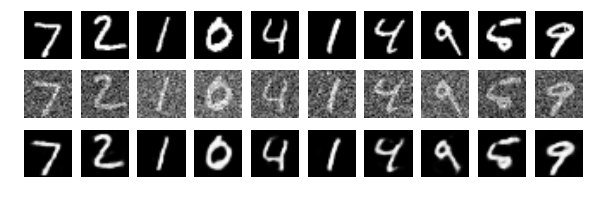

In [6]:
no_plot_img = 10
plt.rcParams['figure.figsize'] = (10, 3)
fig, ax_list = plt.subplots(3, no_plot_img)
for i in range(no_plot_img):
    image = mnist.test.images[i].reshape((28, 28))
    ax_list[0][i].axis('off')
    ax_list[0][i].imshow(image, cmap='gray')
    image = X_test_noisy[i].reshape((28, 28))
    ax_list[1][i].axis('off')
    ax_list[1][i].imshow(image, cmap='gray')
    image = H_test[i].reshape((28, 28))
    ax_list[2][i].axis('off')
    ax_list[2][i].imshow(image, cmap='gray')
plt.show()

## Result visualization: weights

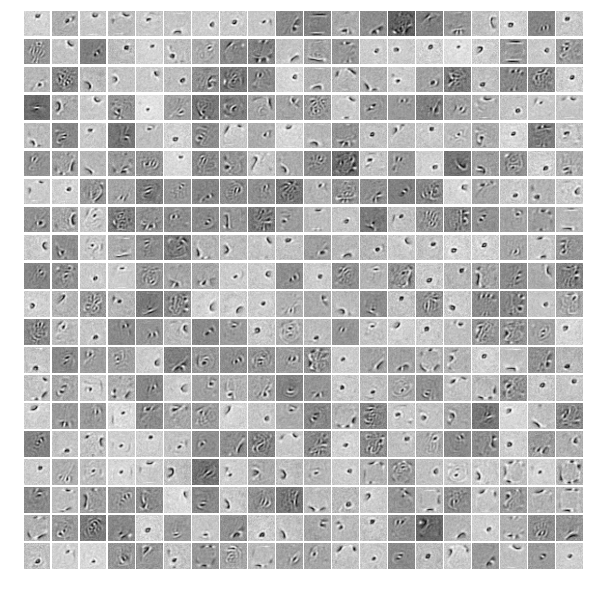

In [7]:
tile_size = int(np.sqrt(weights.shape[0]))
tile_len = int(np.sqrt(weights.shape[1]))
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax_list = plt.subplots(tile_size, tile_size)
for row_i in range(tile_size):
    for col_i in range(tile_size):
        image = weights[row_i * tile_size + col_i]
        max_val = np.max(image)
        min_val = np.min(image)
        norm_image = image
        norm_image = norm_image.reshape((tile_len, tile_len))
        ax_list[row_i][col_i].axis('off')
        ax_list[row_i][col_i].imshow(norm_image, cmap='gray')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()